# Homework 7: scikit-image

Due Tuesday Apr 10, 6pm

## Counting objects

In class, we saw how to count the number of objects in a microscopy image.  Here, we will repeat that exercise, but make use of some of the algorithms in `scikit-image` to segment the image, and then to determine properties of the resulting objects.

As input, use the image `skimage.data.coins`.  Segment the image, and then calculate the area and eccentricity of each coin.

There are various ways to do this.  One would be:

1. Equalize the input image (see `skimage.exposure`)
2. Threshold the image (`skimage.filters.otsu`)
3. Remove objects touching the boundary (`skimage.segmentation.clear_border`)
4. Apply morphological closing (`skimage.morphology.closing`)
5. Remove small objects (`skimage.measure.regionprops`).
   Visualize the results if you want with `skimage.color.label2rgb`.
7. Calculate the area and eccentricity of each coin, and display the
   original image with this information on it (`matplotlib.pyplot.text` or `matplotlib.pyplot.annotate`)

In [44]:
import skimage
from skimage.data import coins
from skimage.exposure import equalize_hist
from skimage.filters import threshold_yen, try_all_threshold, threshold_adaptive, threshold_local
from skimage.segmentation import clear_border
from skimage.morphology import closing
from skimage.measure import regionprops, label
from skimage.color import label2rgb
import matplotlib.pyplot as plt

eq = equalize_hist(coins())
#thresh = threshold_yen(eq)
#try_all_threshold(eq, figsize = (16,10), verbose=0);

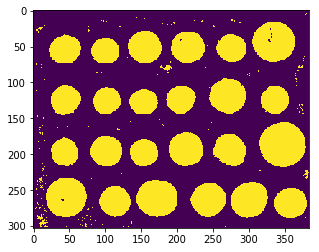

In [45]:
adapt_thresh = threshold_local(eq, 105)
thresholded = eq>adapt_thresh
cleared = clear_border(thresholded)
closed = closing(cleared)
plt.imshow(closed)

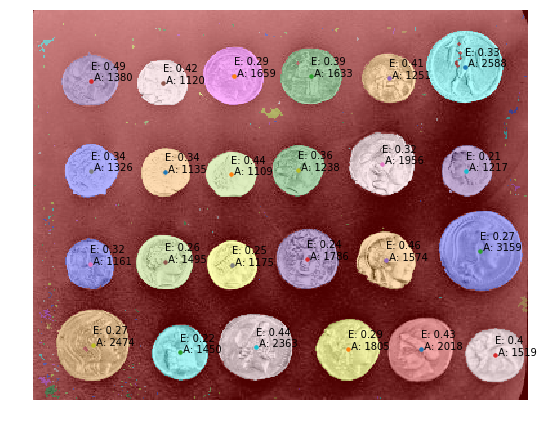

In [58]:
label_image = label(closed)
image_label_overlay = label2rgb(label_image, image=eq)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

kept_regions = []
for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        kept_regions.append(region)
        
        
for region in kept_regions:
    plt.annotate(s='E: ' + str(round(region.eccentricity,2)) + '\n A: ' +
                 str(region.area),
                 xy = (region.centroid[1], region.centroid[0]))
    plt.scatter(region.centroid[1], region.centroid[0], s=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()


## Panorama stitching

One of the scikit-image tutorials shows [how to do panorama stitching](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb).

Take 3 or 4 overlapping photos of your own, and use the procedure described to stitch your own panorama.

## Extra: Image Stacking

Reprocess one of the datasets from http://www.rawastrodata.com/.  See http://www.rawastrodata.com/pages/typesofimages.html for a description of the different kind of images.